mark

In [4]:
N = 56

input_shape = (N, N, 1)#datasets_info.features['image'].shape
encoded_size = 16
base_depth = 32

from xrdc import fourier

In [188]:
from tensorflow.signal import fft

from tensorflow.keras.layers import Lambda
from tensorflow.signal import fft, fft2d, fftshift, ifft2d, ifft2d

import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import numpy as np

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_datasets as tfds
import tensorflow_probability as tfp


tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

# from skimage.transform import resize

from xrdc.source_separation import *
from skimage.transform import resize as sresize
from tensorflow.signal import fft2d, fftshift

    
padx = pady = N // 2
def do_resize():
    #padx = pady = x.shape[1] // 2
    transform = tfkl.AveragePooling2D(2)
    return tfk.Sequential([
        tfk.Input(shape = (N, N, 1)),
        transform
    ])

filt = fourier.lowpass_g(.2, np.ones(N))
probe = (np.einsum('i,j->ij', filt, filt))
tprobe = tf.convert_to_tensor(probe, dtype = 'complex64')

# def do_forward():
#     sequential = do_resize()
#     sequential.add(Lambda(lambda resized: tprobe * (fft2d(
#         tf.squeeze(tf.cast(resized, tf.complex64))
#     ))))
#     sequential.add(Lambda(lambda X: tf.math.real(tf.math.conj(X) * X) / N**2))
#     sequential.add(Lambda(lambda psd: 
#                           tf.expand_dims(
#                               tf.math.sqrt(
#             fftshift(psd, (-2, -1))
#                                    ), 3)))
#     return sequential


def do_forward(sequential = None):
    """
    zero-pad the real-space object and then fourier transform it
    """
    if sequential is None:
        sequential = tfk.Sequential([])
        
    padder = tfkl.ZeroPadding2D((padx // 2, padx // 2))

    sequential.add(padder)
    sequential.add(tfk.Input(shape = (N, N, 1)))
    sequential.add(Lambda(lambda resized: tprobe * (fft2d(
        tf.squeeze(tf.cast(resized, tf.complex64))
    ))))
    sequential.add(Lambda(lambda X: tf.math.real(tf.math.conj(X) * X) / N**2))
    sequential.add(Lambda(lambda psd: 
                          tf.expand_dims(
                              tf.math.sqrt(
            fftshift(psd, (-2, -1))
                                   ), 3)))
    return sequential



# def do_forward():
#     sequential = tfk.Sequential([tfkl.ZeroPadding2D((padx // 2, padx // 2))])
#     sequential.add(Lambda(lambda resized: (fft2d(
#         tf.squeeze(tf.cast(resized, tf.complex64))
#     ))))
#     sequential.add(Lambda(lambda X: tf.math.real(tf.math.conj(X) * X) / N**2))
#     sequential.add(Lambda(lambda psd: 
#                           tf.expand_dims(
#                               tf.math.sqrt(
#             fftshift(psd, (-2, -1))
#                                    ), 3)))
#     return sequential



support_threshold = .1
@tf.function
def get_mask(input):
    import tensorflow as tf
    mask = tf.where(input >= support_threshold, tf.ones_like(input),
                    tf.zeros_like(input))
    return mask

@tf.function
def add_support(input):
    mask = get_mask(input)
    return input * tf.cast(mask, tf.float32)

def resize(x):
    rmod = do_resize()
    rmod.compile(loss = 'mse')
    return rmod.predict(x)

rmod = do_forward()
rmod.compile(loss='mse')
#rmod.fit(x)

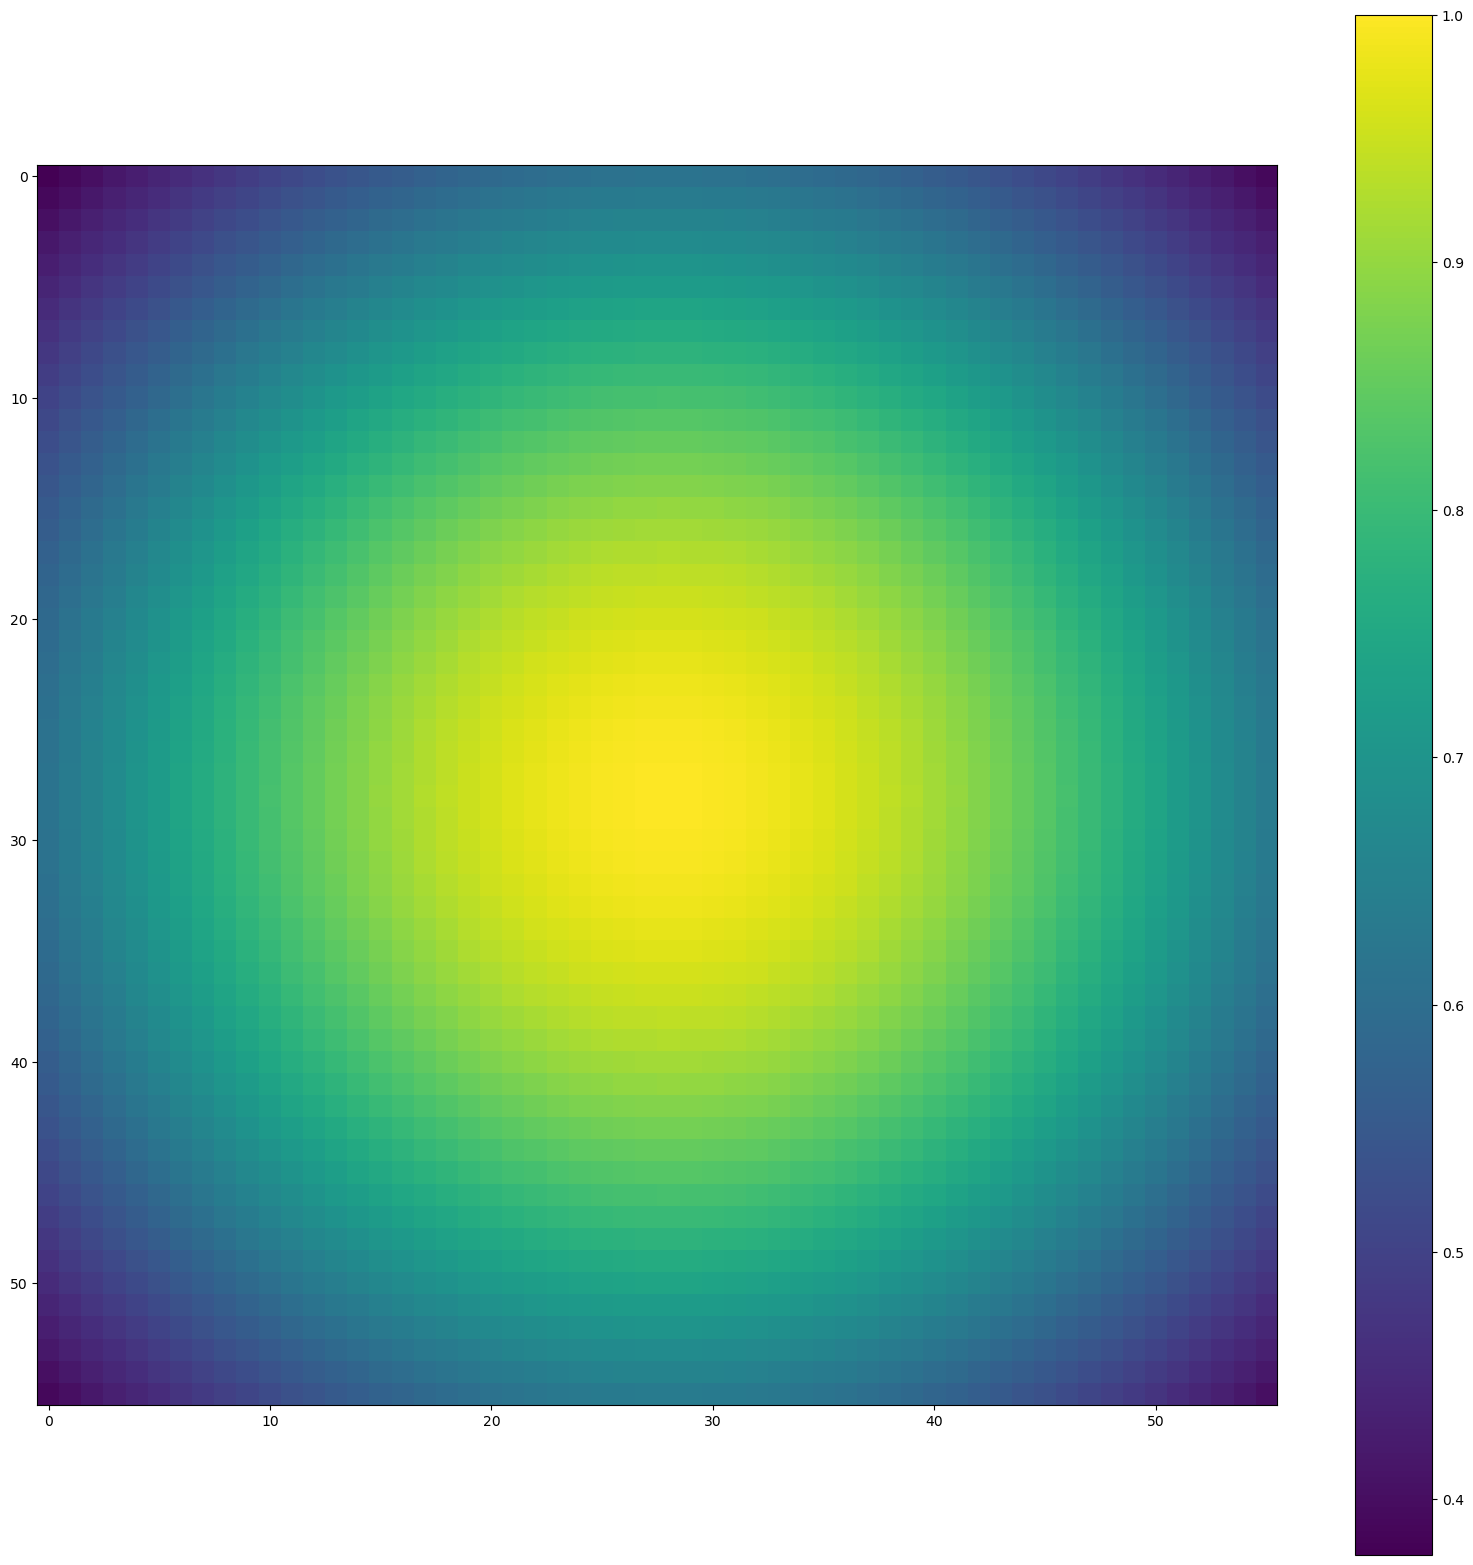

In [73]:
plt.imshow(probe)
plt.colorbar()

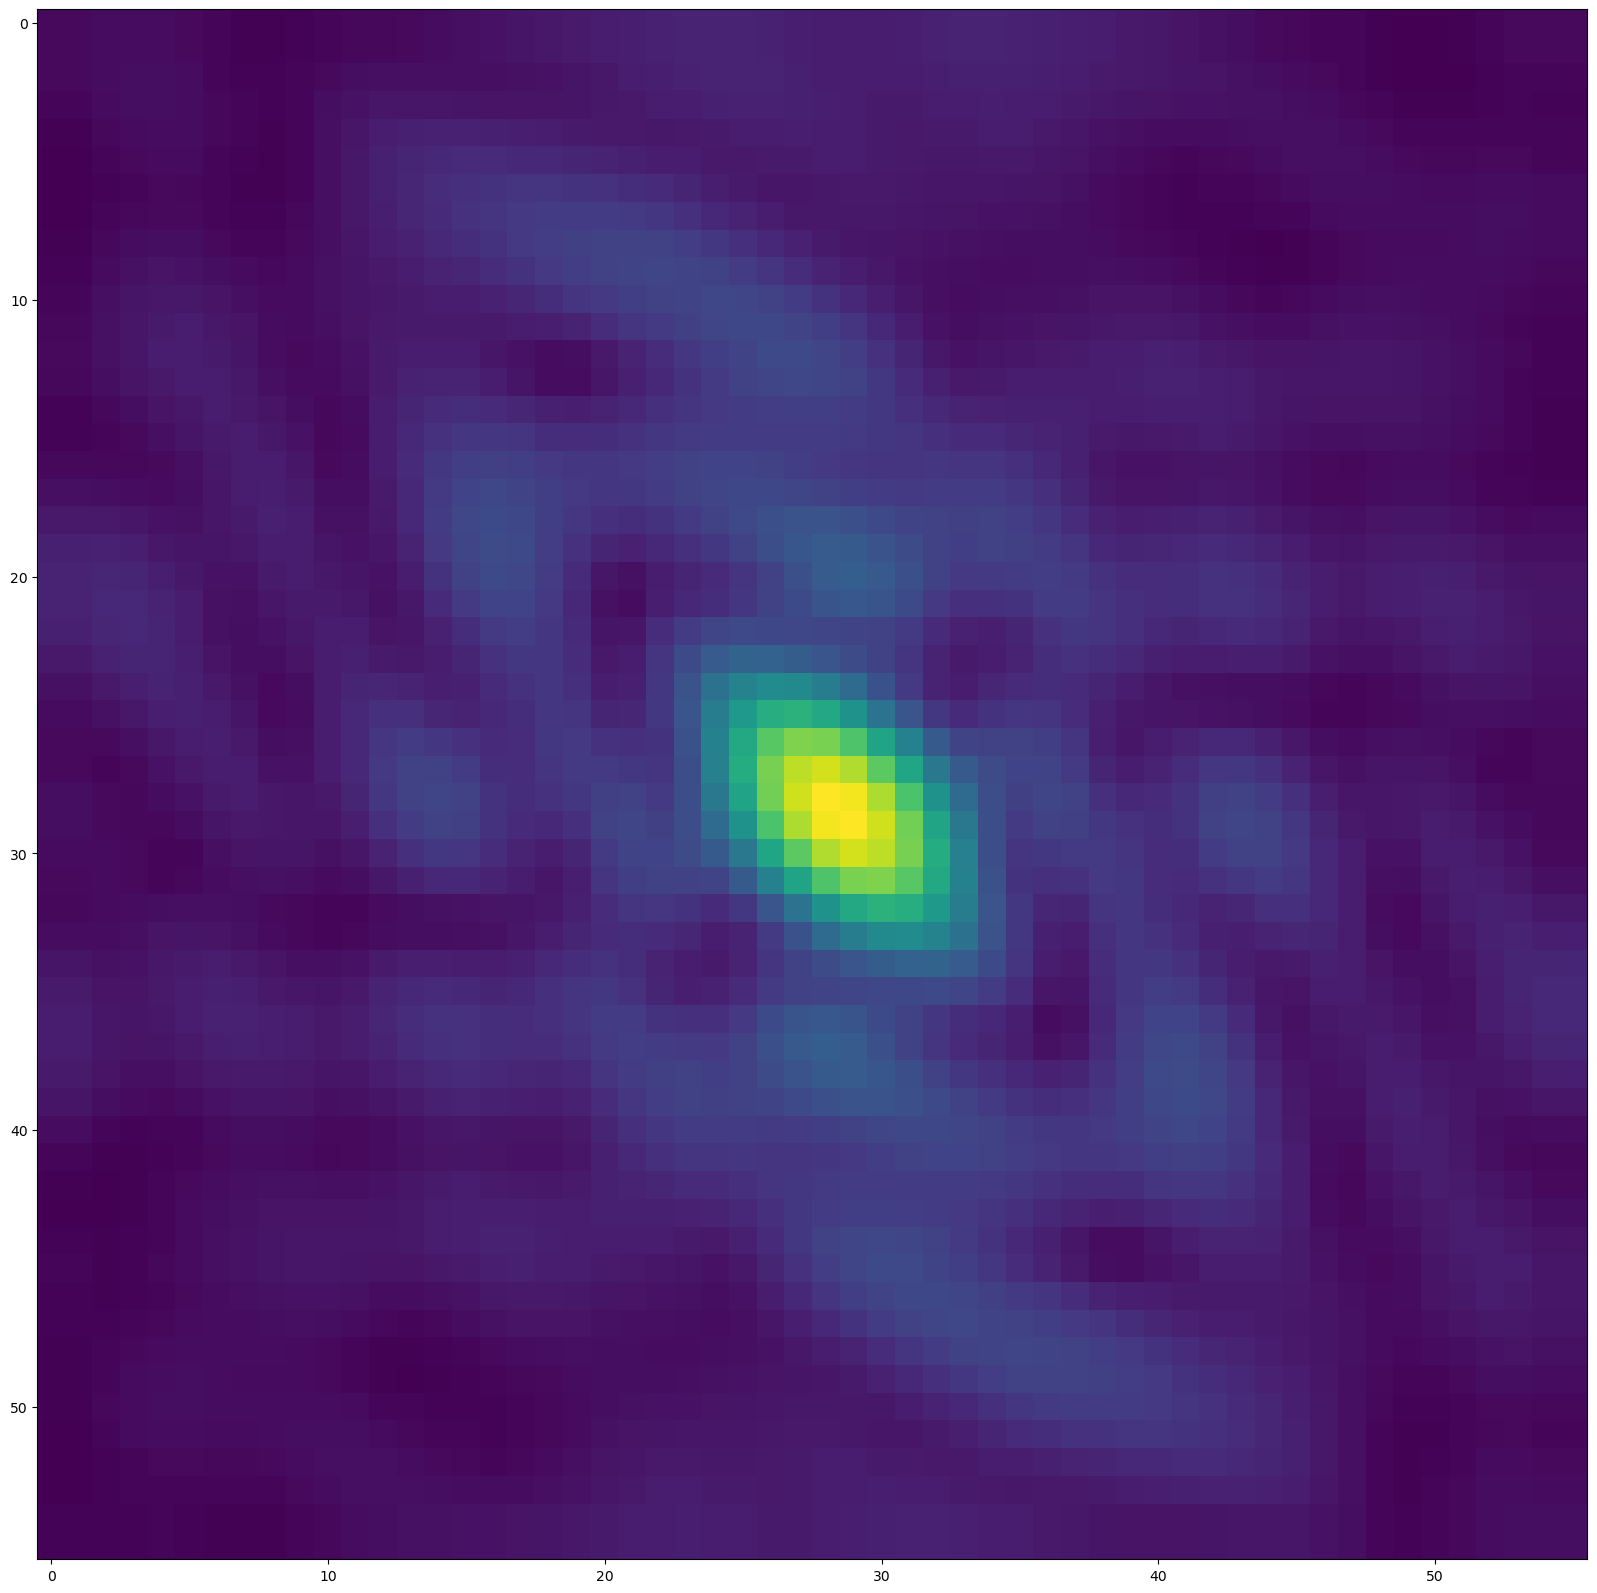

In [168]:
plt.imshow(sresize(np.array(x[0]).squeeze(), (56, 56)))

In [2]:
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.config.experimental.get_memory_usage('GPU:0')

Instructions for updating:
Use tf.config.experimental.get_memory_info(device)['current'] instead.


2560

In [6]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

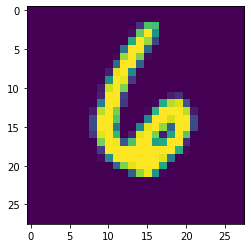

In [46]:
plt.imshow(np.array(x).squeeze()[0])

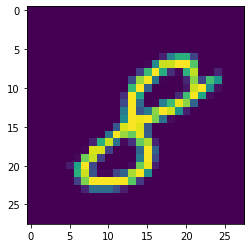

In [505]:
plt.imshow(np.array(x).squeeze()[3])

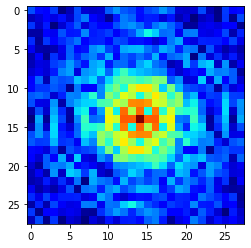

In [579]:
arg0 = fourier.fftshift(power(fourier.fft2((np.array(x).squeeze()[1]))))
plt.imshow(
    np.log(1 + arg0)
, cmap = 'jet')

In [667]:
tmp = ((fourier.fft2((np.array(x).squeeze()[1]))))

In [668]:
mask = (np.abs(fourier.fftfreq(28)) > .25)

In [662]:
tmp[mask, :] = 0

tmp[:, mask] = 0

from scipy.fftpack import ifftshift as sifftshift

In [669]:
tmp2 = (power(fourier.ifft2((tmp))))

In [670]:
tmp2.mean(), np.array(x).squeeze()[1].mean()

(0.22483566, 0.24898957)

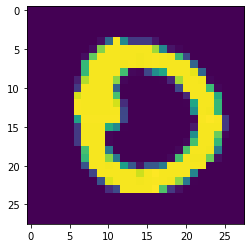

In [671]:
plt.imshow(tmp2)

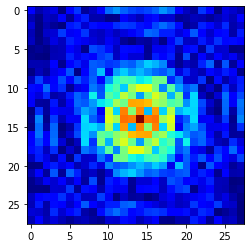

In [672]:
plt.imshow(np.log(4 + power(fourier.fftshift(fourier.fft2(tmp2)))), cmap = 'jet')

In [514]:
resize(x)

1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00


1/1 [==============================] - 0s 19ms/step - loss: 0.0000e+00


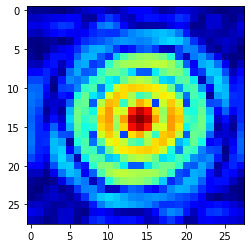

In [658]:
arg = fourier.fftshift(power(fourier.fft2((np.array(
        resize(x)
    ).squeeze()[1]))))
plt.imshow(
    np.log(1 + 
           arg
          )
, cmap = 'jet')

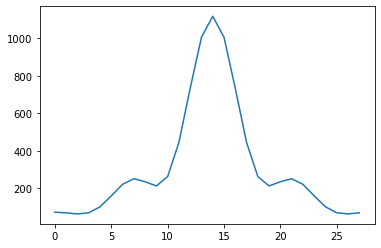

In [526]:
plt.plot(arg.sum(axis = 0))

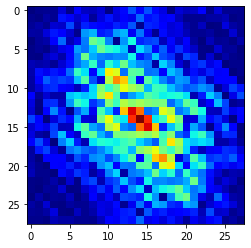

In [548]:
arg2 = fourier.fftshift(power(fourier.fft2((np.array(
        x
    ).squeeze()[3]))))
plt.imshow(
    np.log(4 + 
           arg2
          )
, cmap = 'jet')

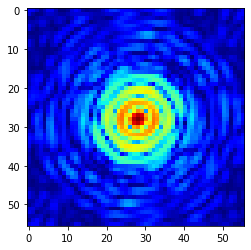

In [577]:
arg3 = fourier.fftshift(power(fourier.fft2(
    np.pad(np.array(x)[1].squeeze(), 14)
    )))

plt.imshow(
    np.log(4 + 
           arg3
          )
, cmap = 'jet')

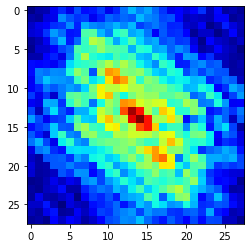

In [564]:
arg4 = arg3[0::2, 0::2] + arg3[0::2, 1::2] + arg3[1::2, 0::2] + arg3[1::2, 1::2]
plt.imshow(
    np.log(4 + 
           arg4
          )
, cmap = 'jet')

In [390]:
ifftshift

<function numpy.fft.ifftshift(x, axes=None)>

In [31]:
# plt.imshow(np.array(x_orig)[3].squeeze())

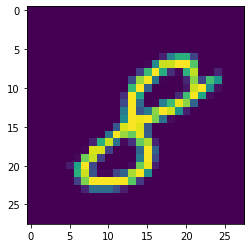

In [538]:
plt.imshow(np.array(x)[3].squeeze())

1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00


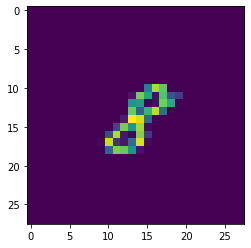

In [539]:
plt.imshow(np.array(resize(x))[3].squeeze())

In [535]:
np.sum(x)

1248.9922

In [533]:
np.sum(resize(x))

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00


312.24805

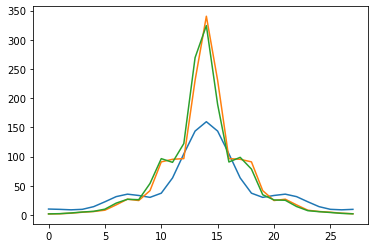

In [561]:
plt.plot(4 * arg.mean(axis = 0))
plt.plot(arg2.mean(axis = 0))
# plt.plot(arg3.mean(axis = 0))
plt.plot(arg4.mean(axis = 0) / 4)

In [112]:
x.shape

TensorShape([10, 42, 42, 1])

In [111]:
rmod.predict(x).shape

1/1 [==============================] - 0s 15ms/step


(10, 56, 56, 1)

1/1 [==============================] - 0s 41ms/step


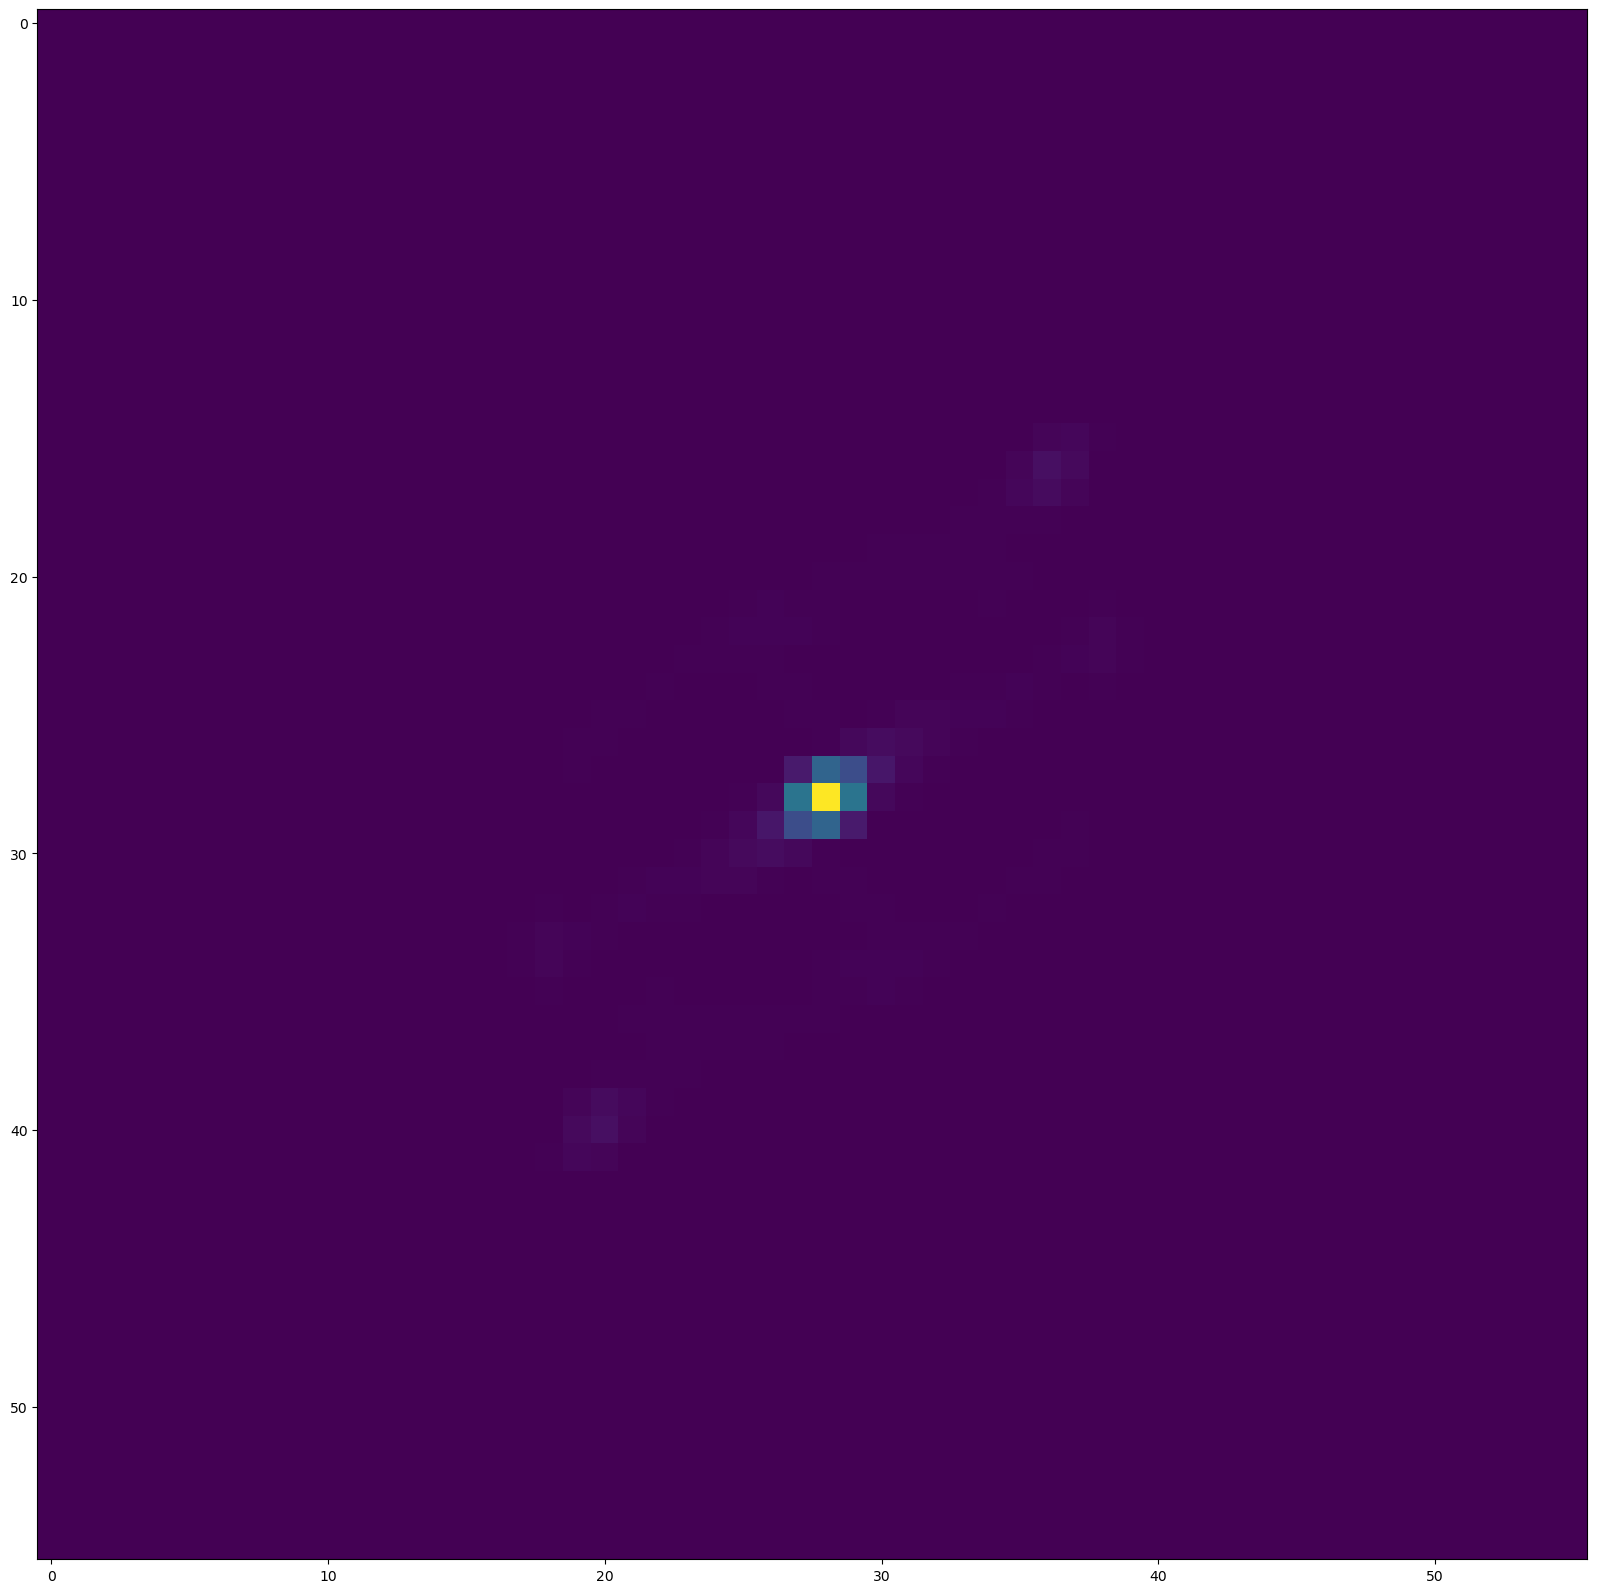

In [110]:
plt.imshow(power(np.array(rmod.predict(x)[3]).squeeze()))

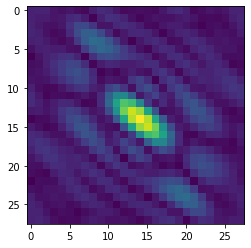

In [487]:
plt.imshow((np.array(rmod.predict(x)[3]).squeeze()))

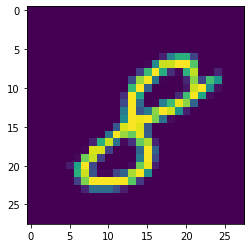

In [394]:
plt.imshow(np.array(x[3]).squeeze())

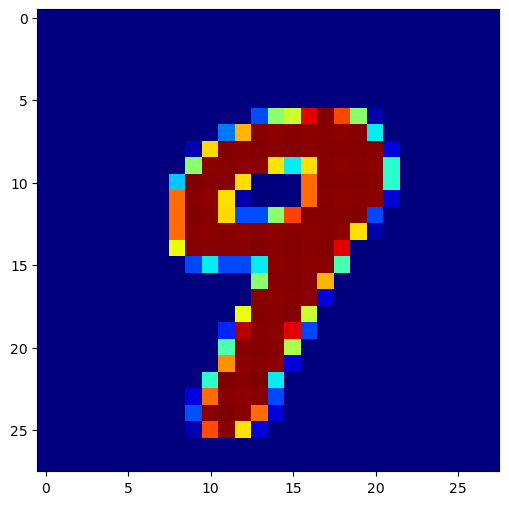

In [43]:
mpl.rcParams['figure.figsize'] =(6, 6)
plt.imshow(np.array(x_orig[3]).squeeze(), cmap = 'jet')

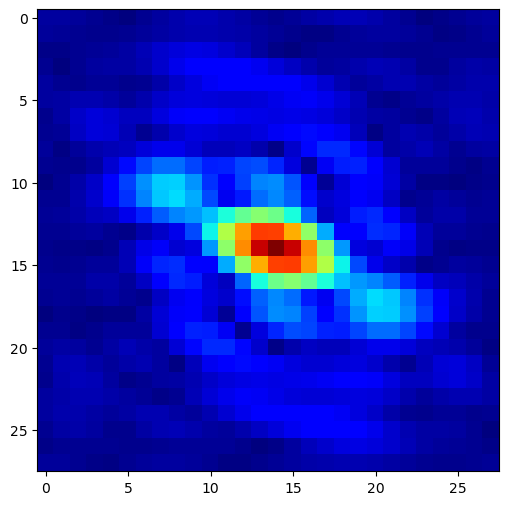

In [42]:
mpl.rcParams['figure.figsize'] =(6, 6)
plt.imshow(np.array(x[3]).squeeze(), cmap = 'jet')

In [44]:
from xrdc import fourier

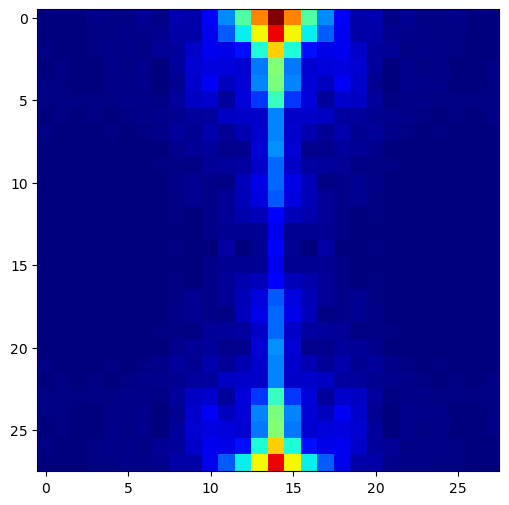

In [52]:
plt.imshow(fourier.fftshift(np.sqrt(fourier.power(fourier.fft2(np.array(x[3])).squeeze()))), cmap = 'jet')

In [ ]:
mpl.rcParams['figure.figsize'] =(6, 6)
plt.imshow(np.array(x[3]).squeeze(), cmap = 'jet')

In [74]:
sys_details = tf.sysconfig.get_build_info()
cuda_version = sys_details["cuda_version"]
print(cuda_version)

11.2


In [75]:
cudnn_version = sys_details["cudnn_version"]  
print(cudnn_version)

8


In [76]:
# tf.debugging.set_log_device_placement(False)

In [169]:
%pdb

Automatic pdb calling has been turned ON


<KerasTensor: shape=(None, 56, 56, 1) dtype=float32 (created by layer 'input_35')>

In [178]:
tfkl.Add()([do_resize(), do_forward()])

TypeError: 'NoneType' object is not subscriptable

> /home/ollie/anaconda3/envs/tf/lib/python3.9/site-packages/keras/layers/merging/base_merge.py(84)build()
     82     def build(self, input_shape):
     83         # Used purely for shape validation.
---> 84         if not isinstance(input_shape[0], tuple):
     85             raise ValueError(
     86                 "A merge layer should be called on a list of inputs. "

ipdb> c


In [174]:
do_forward().input_shape

(None, 56, 56, 1)

In [189]:
datasets, datasets_info = tfds.load(name='mnist',
                                    with_info=True,
                                    as_supervised=False)

# def _preprocess(sample):
#     image = tf.cast(tf.image.resize(sample['image'], [N, N]), 
#                     tf.float32) / 255.  # Scale to unit interval.
#     rmod = do_forward()
#     rmod.compile(loss='mse')
#     orig = tf.identity(image)
#     image = rmod(image)#rmod.predict(image)
#     return image, image, orig

def _preprocess(sample):
    image = tf.cast(tf.image.resize(sample['image'], [N, N]), 
                    tf.float32) / 255.  # Scale to unit interval.
    rmod = do_forward(do_resize())
    rmod.compile(loss='mse')
    orig = tf.identity(image)
    image = rmod(image)#rmod.predict(image)
    return image, image, orig

# with tf.device('/gpu:0'):
train_dataset = (datasets['train']
                 .batch(256)
                 .map(_preprocess)
                 .cache()
                 .prefetch(tf.data.AUTOTUNE)
                 .shuffle(int(10e3)))

# with tf.device('GPU:0'):
#     train_dataset = tf.constant(train_dataset)

# with tf.device('/gpu:0'):
eval_dataset = (datasets['test']
                .batch(256)
                .map(_preprocess)
                .cache()
                .prefetch(tf.data.AUTOTUNE))

In [190]:
x = next(iter(eval_dataset))[0][:10]

2022-09-21 19:53:41.971716: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-09-21 19:53:42.024847: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [191]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)

In [192]:
encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tf.keras.layers.BatchNormalization(),
    tfkl.Conv2D(base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Flatten(),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
               activation=None),
    tfpl.MultivariateNormalTriL(
        encoded_size,
        activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
])


In [193]:
decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[encoded_size]),
    tfkl.Reshape([1, 1, encoded_size]),
    tf.keras.layers.BatchNormalization(),
    tfkl.Conv2DTranspose(2 * base_depth, 7, strides=1,
                         padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    
#     tfkl.Conv2DTranspose(base_depth, 5, strides=2,
#                          padding='same', activation=tf.nn.leaky_relu),
#     tfkl.Conv2DTranspose(base_depth, 5, strides=1,
#                          padding='same', activation=tf.nn.leaky_relu),
    

    tf.keras.layers.BatchNormalization(),
#     tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
#                 padding='same', activation=None),
    tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
                padding='same', activation=tf.nn.sigmoid),
    
#      tfkl.Reshape((input_shape)),
   tfkl.Reshape((input_shape[0] // 2, input_shape[1] // 2, 1)),

##     Lambda(lambda x: tf.clip_by_value(x, 0, 1))
    
#     # impose real space support
#     Lambda(lambda x: add_support(x),
#                     name='masked_obj')
    
])

decoder2 = tfk.Sequential([
    tfkl.InputLayer(input_shape = tf.TensorShape([None, None, None])),
    do_forward(),
    tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc = t, scale = 0.003))),
])


In [194]:
# vae = tfk.Model(inputs=encoder.inputs,
#                 outputs=decoder(encoder.outputs[0]))

vae = tfk.Model(inputs=encoder.inputs,
                outputs=decoder2(decoder(encoder.outputs[0])))

In [195]:
for layer in decoder.layers:
    print(layer.name, layer.output_shape)

reshape_14 (None, 1, 1, 16)
batch_normalization_22 (None, 1, 1, 16)
conv2d_transpose_54 (None, 7, 7, 64)
conv2d_transpose_55 (None, 7, 7, 64)
conv2d_transpose_56 (None, 14, 14, 64)
conv2d_transpose_57 (None, 14, 14, 32)
conv2d_transpose_58 (None, 28, 28, 32)
conv2d_transpose_59 (None, 28, 28, 32)
batch_normalization_23 (None, 28, 28, 32)
conv2d_47 (None, 28, 28, 1)
reshape_15 (None, 28, 28, 1)


In [196]:
for layer in decoder2.layers:
    print(layer.name, layer.output_shape)

sequential_100 None
distribution_lambda_7 (None, None)


In [199]:
negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
            loss=negloglik)

In [204]:
_ = vae.fit(train_dataset,
            epochs=5,
            validation_data=eval_dataset)

Epoch 1/5
235/235 [==============================] - ETA: 0s - loss: 2290.4673WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


235/235 [==============================] - 11s 45ms/step - loss: 2290.4673 - val_loss: 2521.0818
Epoch 2/5
235/235 [==============================] - ETA: 0s - loss: 2251.6208WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


235/235 [==============================] - 11s 45ms/step - loss: 2251.6208 - val_loss: 2478.2251
Epoch 3/5
235/235 [==============================] - ETA: 0s - loss: 2227.6997WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


235/235 [==============================] - 11s 45ms/step - loss: 2227.6997 - val_loss: 2534.0828
Epoch 4/5
235/235 [==============================] - ETA: 0s - loss: 2197.1008WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


235/235 [==============================] - 11s 45ms/step - loss: 2197.1008 - val_loss: 2428.8884
Epoch 5/5
235/235 [==============================] - ETA: 0s - loss: 2173.9028WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


235/235 [==============================] - 11s 45ms/step - loss: 2173.9028 - val_loss: 2437.4783


In [18]:
# !pip install pydot

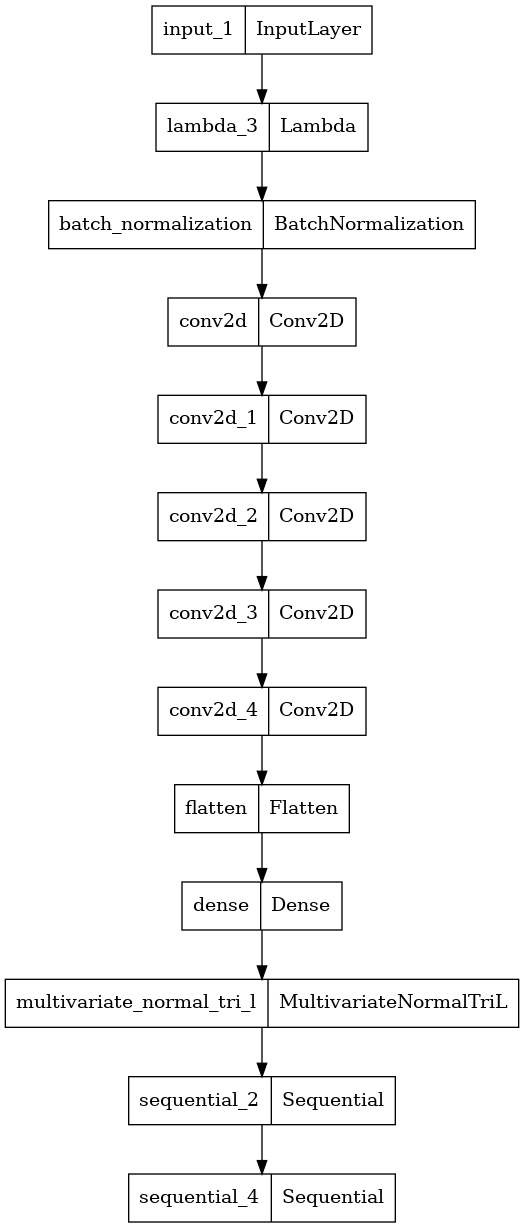

In [23]:
tf.keras.utils.plot_model(vae, 'foo.png')

In [127]:
import matplotlib.pyplot as plt

def display_imgs(x, y=None, log = True, cbar = False):
  if not isinstance(x, (np.ndarray, np.generic)):
    x = np.array(x)
  #plt.ioff()
  n = x.shape[0]
  fig, axs = plt.subplots(1, n, figsize=(n, 2))
  if y is not None:
    fig.suptitle(np.argmax(y, axis=1))
  for i in range(n):
    if log:
        axs.flat[i].imshow(np.log(.01 + x[i].squeeze()), interpolation='none', cmap='jet')
    else:
        axs.flat[i].imshow((x[i].squeeze()), interpolation='none', cmap='jet')
    axs.flat[i].axis('off')
  if cbar:
    plt.colorbar()
  plt.show()
  plt.close()
  plt.ion()

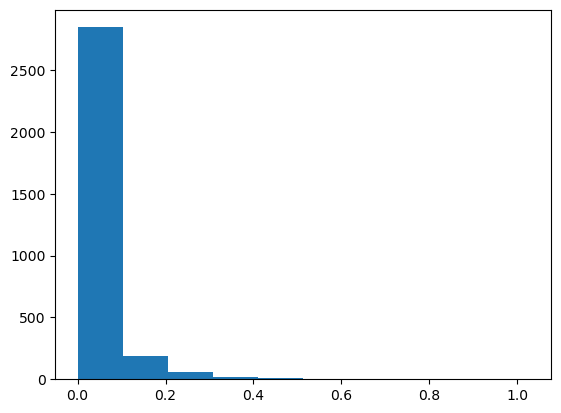

In [25]:
plt.hist(np.array(tf.squeeze(x[5])).ravel());

In [67]:
# plt.imshow(np.array((decoder(encoder(x)))).squeeze()[4], cmap = 'jet')

# plt.imshow(np.array(resize((x_orig))).squeeze()[2], cmap = 'jet')

# plt.imshow(np.array(resize(decoder(encoder(x)))).squeeze()[2], cmap = 'jet')

In [68]:
# plt.imshow(np.array(decoder2(decoder(encoder(x))).mean()).squeeze()[0], cmap = 'jet')

In [26]:
from xrdc import fourier

Diffraction:


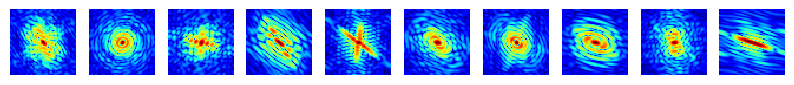

Decoded Random Samples (top: reconstruction; bottom: diffraction):


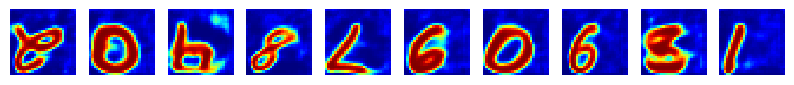

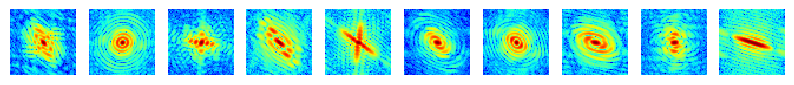

Decoded Modes:


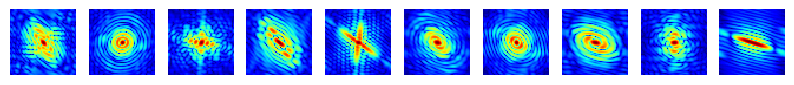

True object


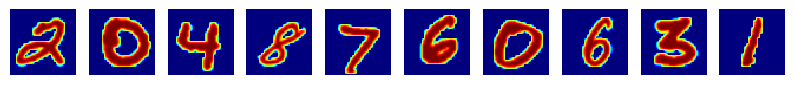

Reconstructed object (mode)


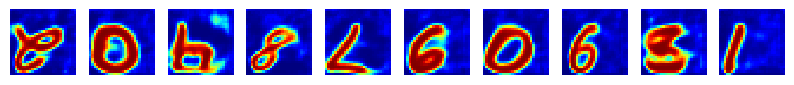

Reconstructed object variance


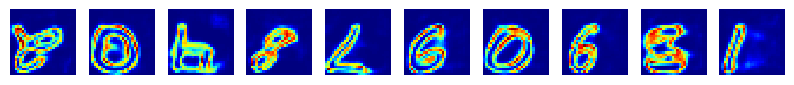

0.049422492664308273

In [205]:
x_orig = next(iter(eval_dataset))[2][:10]

# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0][:10]
xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

import matplotlib as mpl
mpl.rcParams['figure.figsize'] =(20, 20)

print('Diffraction:')
display_imgs(x)

print('Decoded Random Samples (top: reconstruction; bottom: diffraction):')
tmp = decoder(encoder(x))
display_imgs(tmp)
display_imgs(decoder2(tmp).sample())

print('Decoded Modes:')
display_imgs(xhat.mode())

# print('Decoded Means:')
# display_imgs(xhat.mean())

print("True object")
display_imgs((x_orig))

print("Reconstructed object (mode)")
display_imgs((decoder(encoder(x).mode())))

print('Reconstructed object variance')
#tmp = tf.stack([vae(x).sample() for _ in range(100)])
tmp = tf.stack([decoder(encoder(x)) for _ in range(100)])
display_imgs((np.array(tmp).std(axis = 0)))
np.percentile(np.array(tmp).std(axis = 0).ravel(), 99.9)

Diffraction:


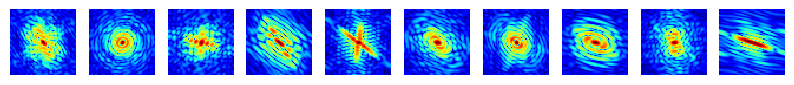

Decoded Random Samples (top: reconstruction; bottom: diffraction):


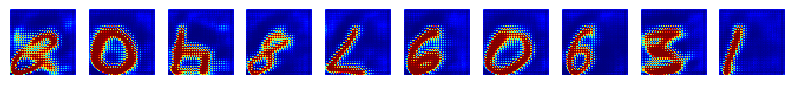

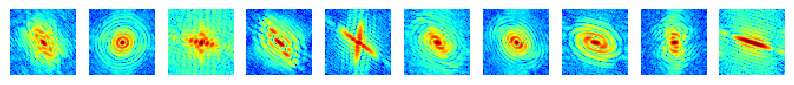

Decoded Modes:


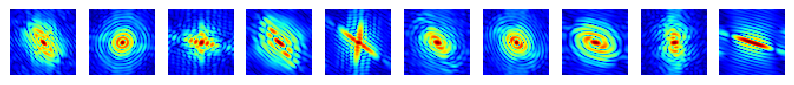

True object


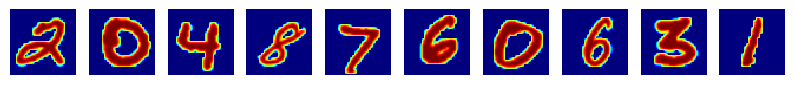

Reconstructed object (mode)


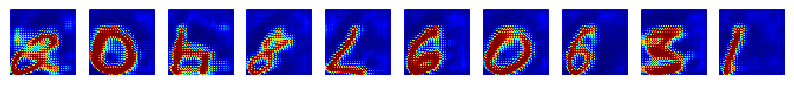

Reconstructed object variance


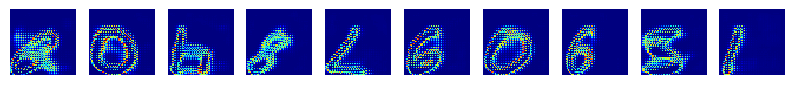

0.11657939741760567

In [140]:
x_orig = next(iter(eval_dataset))[2][:10]

# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0][:10]
xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

import matplotlib as mpl
mpl.rcParams['figure.figsize'] =(20, 20)

print('Diffraction:')
display_imgs(x)

print('Decoded Random Samples (top: reconstruction; bottom: diffraction):')
tmp = decoder(encoder(x))
display_imgs(tmp)
display_imgs(decoder2(tmp).sample())

print('Decoded Modes:')
display_imgs(xhat.mode())

# print('Decoded Means:')
# display_imgs(xhat.mean())

print("True object")
display_imgs((x_orig))

print("Reconstructed object (mode)")
display_imgs((decoder(encoder(x).mode())))

print('Reconstructed object variance')
#tmp = tf.stack([vae(x).sample() for _ in range(100)])
tmp = tf.stack([decoder(encoder(x)) for _ in range(100)])
display_imgs((np.array(tmp).std(axis = 0)))
np.percentile(np.array(tmp).std(axis = 0).ravel(), 99.9)

In [120]:
xhat.sample()

<tf.Tensor: shape=(10, 56, 56, 1), dtype=float32, numpy=
array([[[[-4.57427348e-04],
         [-1.62523263e-03],
         [ 3.04545974e-05],
         ...,
         [-2.19237106e-03],
         [ 3.65259545e-03],
         [-1.93659426e-03]],

        [[ 3.72420345e-03],
         [ 4.80304705e-03],
         [ 2.90967547e-03],
         ...,
         [ 8.82782135e-03],
         [ 9.21213999e-03],
         [ 5.39500965e-04]],

        [[ 4.82636504e-03],
         [ 2.65030749e-03],
         [ 4.03299881e-03],
         ...,
         [ 6.64016511e-03],
         [ 5.17988298e-03],
         [-1.51393446e-03]],

        ...,

        [[ 2.86816945e-03],
         [ 2.96006654e-03],
         [-1.33702043e-03],
         ...,
         [ 1.02478424e-02],
         [-5.80237014e-04],
         [-2.76588672e-03]],

        [[ 1.53418817e-03],
         [ 7.06893206e-03],
         [ 3.22111277e-03],
         ...,
         [ 3.75112053e-04],
         [ 2.24837218e-03],
         [ 3.77715542e-03]],

        [

Illuminated object
1/1 [==============================] - 0s 20ms/step


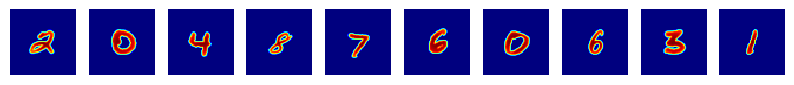

In [71]:
print("Illuminated object")
display_imgs(resize((x_orig) * 
                    tf.convert_to_tensor(probe, dtype= 'float')[:, :, None]
                   )
            )

Diffraction:


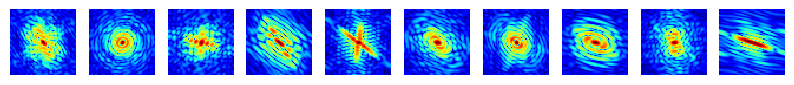

Decoded Random Samples:


/tmp/ipykernel_157442/3046691751.py:13: RuntimeWarning: invalid value encountered in log
  axs.flat[i].imshow(np.log(.01 + x[i].squeeze()), interpolation='none', cmap='jet')


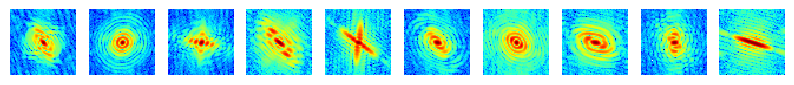

Decoded Modes:


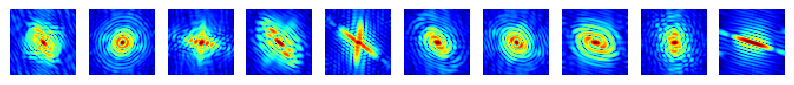

Decoded Means:


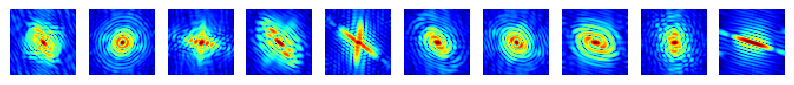

True object
1/1 [==============================] - 0s 20ms/step


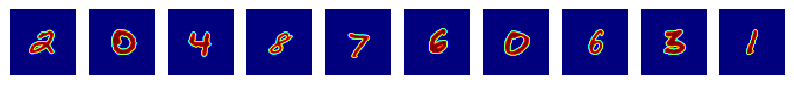

Reconstructed object
1/1 [==============================] - 0s 20ms/step


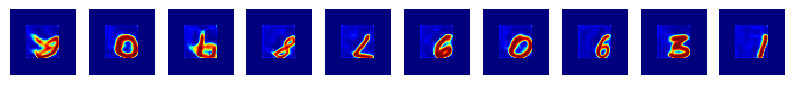

Variance


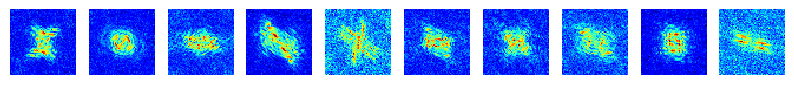

0.0034505879

In [29]:
x_orig = next(iter(eval_dataset))[2][:10]

# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0][:10]
xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

import matplotlib as mpl
mpl.rcParams['figure.figsize'] =(20, 20)

print('Diffraction:')
display_imgs(x)

print('Decoded Random Samples:')
display_imgs(xhat.sample())

print('Decoded Modes:')
display_imgs(xhat.mode())

print('Decoded Means:')
display_imgs(xhat.mean())

print("True object")
display_imgs(resize(x_orig))

print("Reconstructed object")
display_imgs(resize(decoder(encoder(x).mode())))

print('Variance')
tmp = tf.stack([vae(x).sample() for _ in range(100)])
display_imgs((np.array(tmp).std(axis = 0)))
np.array(tmp).std(axis = 0).mean()

Diffraction:


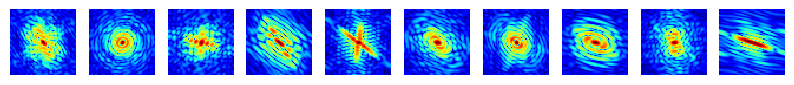

Decoded Random Samples:


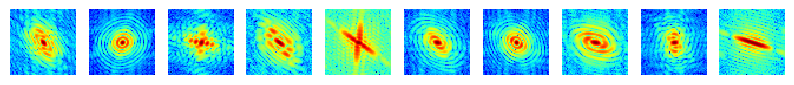

Decoded Modes:


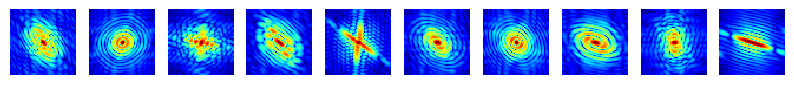

Decoded Means:


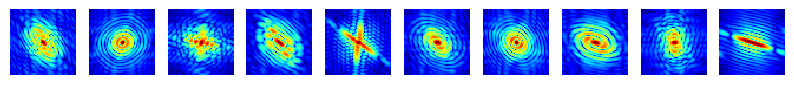

True object
1/1 [==============================] - 0s 20ms/step


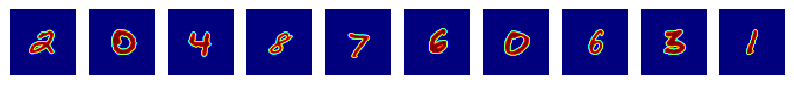

Reconstructed object
1/1 [==============================] - 0s 20ms/step


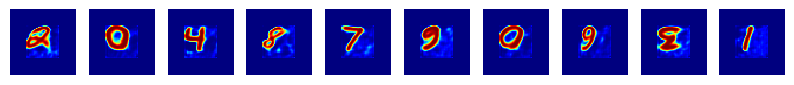

Variance


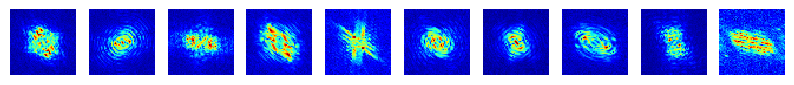

0.0034961721

In [436]:
x_orig = next(iter(eval_dataset))[2][:10]

# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0][:10]
xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

import matplotlib as mpl
mpl.rcParams['figure.figsize'] =(20, 20)

print('Diffraction:')
display_imgs(x)

print('Decoded Random Samples:')
display_imgs(xhat.sample())

print('Decoded Modes:')
display_imgs(xhat.mode())

print('Decoded Means:')
display_imgs(xhat.mean())

print("True object")
display_imgs(resize(x_orig))

print("Reconstructed object")
display_imgs(resize(decoder(encoder(x).mode())))

print('Variance')
tmp = tf.stack([vae(x).sample() for _ in range(100)])
display_imgs((np.array(tmp).std(axis = 0)))
np.array(tmp).std(axis = 0).mean()

Illuminated object
1/1 [==============================] - 0s 21ms/step


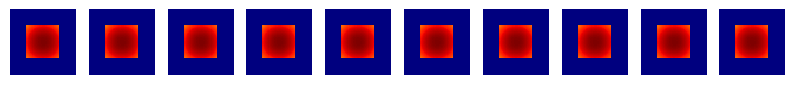

In [434]:
print("Illuminated object")
display_imgs(resize(tf.ones_like(x_orig) * 
                    tf.convert_to_tensor(probe, dtype= 'float')[:, :, None]
                   )
            )

In [360]:
# mkdir models/mnist_fourier_vae/

In [1]:
vae.save('models/mnist_fourier_vae/vae.h5')

encoder.save('models/mnist_fourier_vae/encoder.h5')

decoder.save('models/mnist_fourier_vae/decoder.h5')

decoder2.save('models/mnist_fourier_vae/decoder2.h5')

NameError: name 'vae' is not defined

Randomly Generated Samples:


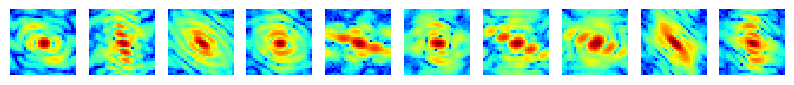

Randomly Generated Modes:


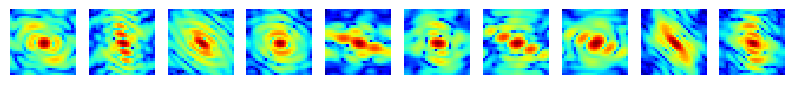

Randomly Generated Means:


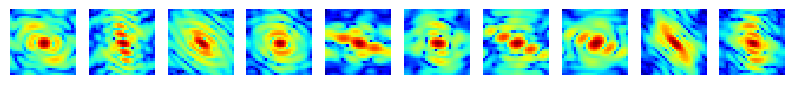

1/1 [==============================] - 0s 20ms/step


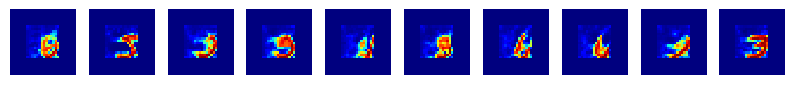

1/1 [==============================] - 0s 20ms/step


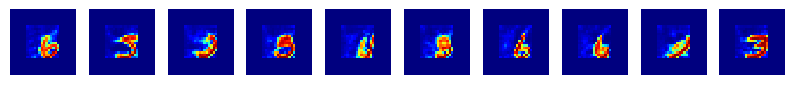

In [23]:
# Now, let's generate ten never-before-seen digits.
z = prior.sample(10)
xtilde = decoder2(decoder(z))
assert isinstance(xtilde, tfd.Distribution)

print('Randomly Generated Samples:')
samp = xtilde.sample()
display_imgs(samp)

print('Randomly Generated Modes:')
display_imgs(xtilde.mode())

print('Randomly Generated Means:')
display_imgs(xtilde.mean())

display_imgs(resize(decoder(z)))

display_imgs(resize(decoder(encoder(samp))))

Randomly Generated Samples:


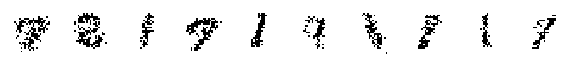

Randomly Generated Modes:


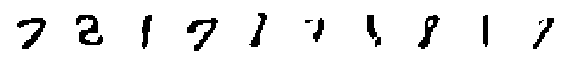

Randomly Generated Means:


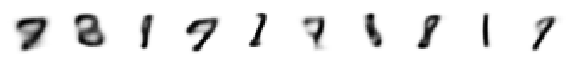

In [455]:
print('Randomly Generated Samples:')
display_imgs(xtilde.sample())

print('Randomly Generated Modes:')
display_imgs(xtilde.mode())

print('Randomly Generated Means:')
display_imgs(xtilde.mean())

In [522]:
import os

import numpy as np
import torch
from pyro.contrib.examples.util import MNIST
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [523]:
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

In [542]:
do_forward(nn.ZeroPad2d((0, 1, 0, 1))(x)).shape

torch.Size([16, 1, 29, 29])

In [543]:
# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = './data'
    download = True
    trans = transforms.Compose([transforms.ToTensor(),
                                nn.ZeroPad2d((0, 1, 0, 1)),
                                do_forward])
    train_set = MNIST(root=root, train=True, transform=trans,
                      download=download)
    test_set = MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [544]:
import torchvision

In [586]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, N**2)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()
        self.z_dim = z_dim
        
        base_depth = 32
        
        
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(1, 2 * base_depth, 7, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(2 * base_depth),
            nn.LeakyReLU()
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(2 * base_depth, 2 * base_depth, kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm2d(2 * base_depth),
            nn.LeakyReLU())
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(2 * base_depth, 2 * base_depth, kernel_size=5, stride=2, padding='same'),
            nn.BatchNorm2d(2 * base_depth),
            nn.LeakyReLU()
        )
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(2 * base_depth, base_depth, kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm2d(base_depth),
            nn.LeakyReLU())
        
        self.layer5 = nn.Sequential(
            nn.ConvTranspose2d(base_depth, base_depth, kernel_size=5, stride=2, padding='same'),
            nn.BatchNorm2d(base_depth),
            nn.LeakyReLU())
        
        self.layer6 = nn.Sequential(
            nn.ConvTranspose2d(base_depth, base_depth, kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm2d(base_depth),
            nn.LeakyReLU())
        
        self.layer7 = nn.Sequential(
            nn.Conv2d(base_depth, 1, kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm2d(base_depth)  
    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output distribution
        # each is of size batch_size x (flattened data size)
        loc_img = self.sigmoid(self.fc21(hidden)).reshape(-1, N, N)
        blur = torchvision.transforms.GaussianBlur(5, sigma=(.8, .8))

        return blur(loc_img)

In [587]:
import torch.nn.functional as F

In [588]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim = 7*7*16):
        super().__init__()
        
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #self.fc1 = nn.Linear(7*7*32, hidden_dim)

#         self.layer1 = nn.Sequential(
#             nn.Conv2d(1, base_depth, kernel_size=5, stride=1, padding='same'),
#             nn.BatchNorm2d(base_depth),
#             nn.LeakyReLU()
#         )
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(base_depth, base_depth, kernel_size=5, stride=2, padding='same'),
#             nn.BatchNorm2d(base_depth),
#             nn.LeakyReLU())
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(base_depth, 2 * base_depth, kernel_size=5, stride=1, padding='same'),
#             nn.BatchNorm2d(2 * base_depth),
#             nn.LeakyReLU()
#         )
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(2 * base_depth, 2 * base_depth, kernel_size=5, stride=2, padding='same'),
#             nn.BatchNorm2d(2 * base_depth),
#             nn.LeakyReLU())
        
        
        
        # setup the three linear transformations used
        #self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x


        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        #hidden = self.softplus(self.fc1(out))
        hidden = self.softplus(out)

#         # first shape the mini-batch to have pixels in the rightmost dimension
#         x = x.reshape(-1, 784)
        # then compute the hidden units
        #hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [589]:
obs_sigma = .05

In [591]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=7*7*16, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        #x = do_forward(x)
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z

            loc_img = do_forward(
                    self.decoder(z)
                ).reshape(-1, N**2)
            # score against actual images
            #pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))
            return pyro.sample("obs", dist.Normal(loc_img, obs_sigma).to_event(1),
                               obs=x.reshape(-1, N**2))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        #x = do_forward(x)
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

In [592]:
do_forward(x[10]).max()

tensor(0.4922)

In [593]:
vae = VAE()

In [594]:
optimizer = Adam({"lr": 1.0e-3})

In [595]:
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

In [596]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [597]:
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x, _ in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test